## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [74]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [75]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
740000,1058071,14053,69,4889,97.0
2534344,989621,15297,158,30080,100.0
2844714,179871,763,56,5093,82.0
3950720,949830,12323,97,6661,100.0
4280297,691541,8482,152,896,19.0


Сделаем разбиение по времени

<Axes: >

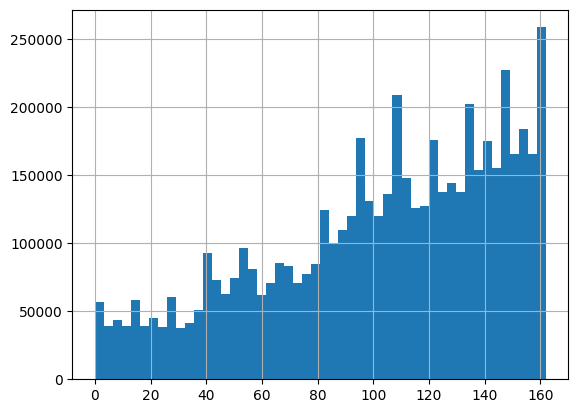

In [76]:
df.last_watch_dt.hist(bins=50)

In [77]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [78]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [79]:
n_users = 10000

# Устанвоим seed для генератора случайных чисел
np.random.seed(142)

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [80]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1,699317,1659,77,8317,100.0
49,474544,10440,95,36469,90.0
112,490158,817,139,930,16.0
121,538575,11332,98,71721,100.0
123,514235,8391,147,3570,57.0


In [81]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-81-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-81-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161..."
1,109,"[(11047, 146)]"
2,119,"[(9728, 134), (4436, 135)]"
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124..."
4,495,"[(1136, 6)]"


In [82]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158..."
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]"
2,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]"
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]"
4,495,"[(1136, 6)]","[(16244, 153), (5434, 153), (4946, 155), (1236..."


In [83]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[10077, 5415, 1308]"
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[10077, 5415, 1308]"
2,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[10077, 5415, 1308]"
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[10077, 5415, 1308]"
4,495,"[(1136, 6)]","[(16244, 153), (5434, 153), (4946, 155), (1236...","[10077, 5415, 1308]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [84]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None):

    if topn is None:
        topn = len(predictions)

    predictions = np.array(predictions[:topn])
    gt_items = set(gt_items)

    # массив релевантности
    relevance = np.isin(predictions, list(gt_items)).astype(int)

    cumulative_relevance = np.cumsum(relevance)

    precision_at_k = cumulative_relevance / (np.arange(len(relevance)) + 1)

    average_precision = np.sum(precision_at_k * relevance) / min(topn, len(gt_items))

    return average_precision

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    predictions = np.array(predictions[:topn])
    gt_items = set(gt_items)
    relevance = np.isin(predictions, list(gt_items)).astype(int)
    first_relevant_index = np.argmax(relevance) if np.any(relevance) else -1

    if first_relevant_index == -1:
        return 0.0
    return 1.0 / (first_relevant_index + 1)

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    predictions = np.array(predictions[:topn])
    gt_items = set(gt_items)
    relevance = np.isin(predictions, list(gt_items)).astype(int)
    return int(np.any(relevance))


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [85]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [86]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [87]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0004277777777777778, 'mrr': 0.0010333333333333332, 'hr': 0.0013}

In [88]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[10077, 5415, 1308]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[10077, 5415, 1308]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[10077, 5415, 1308]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[10077, 5415, 1308]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,495,"[(1136, 6)]","[(16244, 153), (5434, 153), (4946, 155), (1236...","[10077, 5415, 1308]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [89]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.0693765998834719, 'mrr': 0.122153373015873, 'hr': 0.2799}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [90]:
class TopPopularWeighted(TopPopular):
    def __init__(self, min_window=5):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions', timestamp_col='timestamp'):
        item_counts = {}

        all_timestamps = [timestamp for row in df[col] for _, timestamp in row]

        if not all_timestamps:
            return

        latest_time = max(all_timestamps)
        time_threshold = latest_time - self.min_window

        for _, row in df.iterrows():
            recent_interactions = [
                item for item, timestamp in row[col] if timestamp > time_threshold
            ]

            if not recent_interactions:
                continue

            for item in recent_interactions:
                if item in item_counts:
                    item_counts[item] += 1
                else:
                    item_counts[item] = 1

        sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [item for item, _ in sorted_items]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

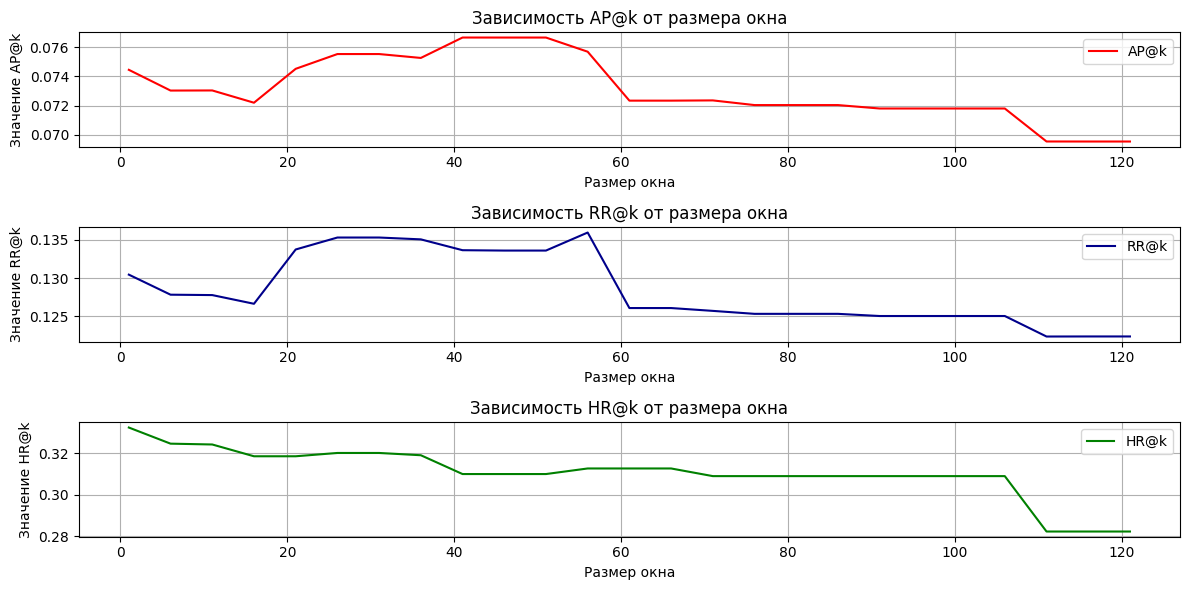

In [91]:
window_sizes = list(range(1, 125, 5))
ap_results = []
rr_results = []
hr_results = []

for window_size in window_sizes:
    model = TopPopularWeighted(min_window=window_size)
    model.fit(joined)
    toppopular_recs = model.predict(joined)

    ap = np.mean([ap_metric([item for item, _ in row['test_interactions']], toppopular_recs[i], topn=10) for i, row in joined.iterrows()])
    rr = np.mean([rr_metric([item for item, _ in row['test_interactions']], toppopular_recs[i], topn=10) for i, row in joined.iterrows()])
    hr = np.mean([hr_metric([item for item, _ in row['test_interactions']], toppopular_recs[i], topn=10) for i, row in joined.iterrows()])

    ap_results.append(ap)
    rr_results.append(rr)
    hr_results.append(hr)


plt.figure(figsize=(12, 6))

# График AP@k
plt.subplot(3, 1, 1)
plt.plot(window_sizes, ap_results, label='AP@k', color='red')
plt.title('Зависимость AP@k от размера окна')
plt.xlabel('Размер окна')
plt.ylabel('Значение AP@k')
plt.legend()
plt.grid(True)

# График RR@k
plt.subplot(3, 1, 2)
plt.plot(window_sizes, rr_results, label='RR@k', color='darkblue')
plt.title('Зависимость RR@k от размера окна')
plt.xlabel('Размер окна')
plt.ylabel('Значение RR@k')
plt.legend()
plt.grid(True)

# График HR@k
plt.subplot(3, 1, 3)
plt.plot(window_sizes, hr_results, label='HR@k', color='green')
plt.title('Зависимость HR@k от размера окна')
plt.xlabel('Размер окна')
plt.ylabel('Значение HR@k')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Еслу увеличивать размер окон, то AP@k и RP@k показывают рост, при достижении своего max наблюдается падение, так как при большом значениии окна мы можем брать нереелвантные данные. HR@k данная метрика изначально показывает спад, что видно пографикам, такое может быть связано с тем, что в нашем случае она работает плохо.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [92]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

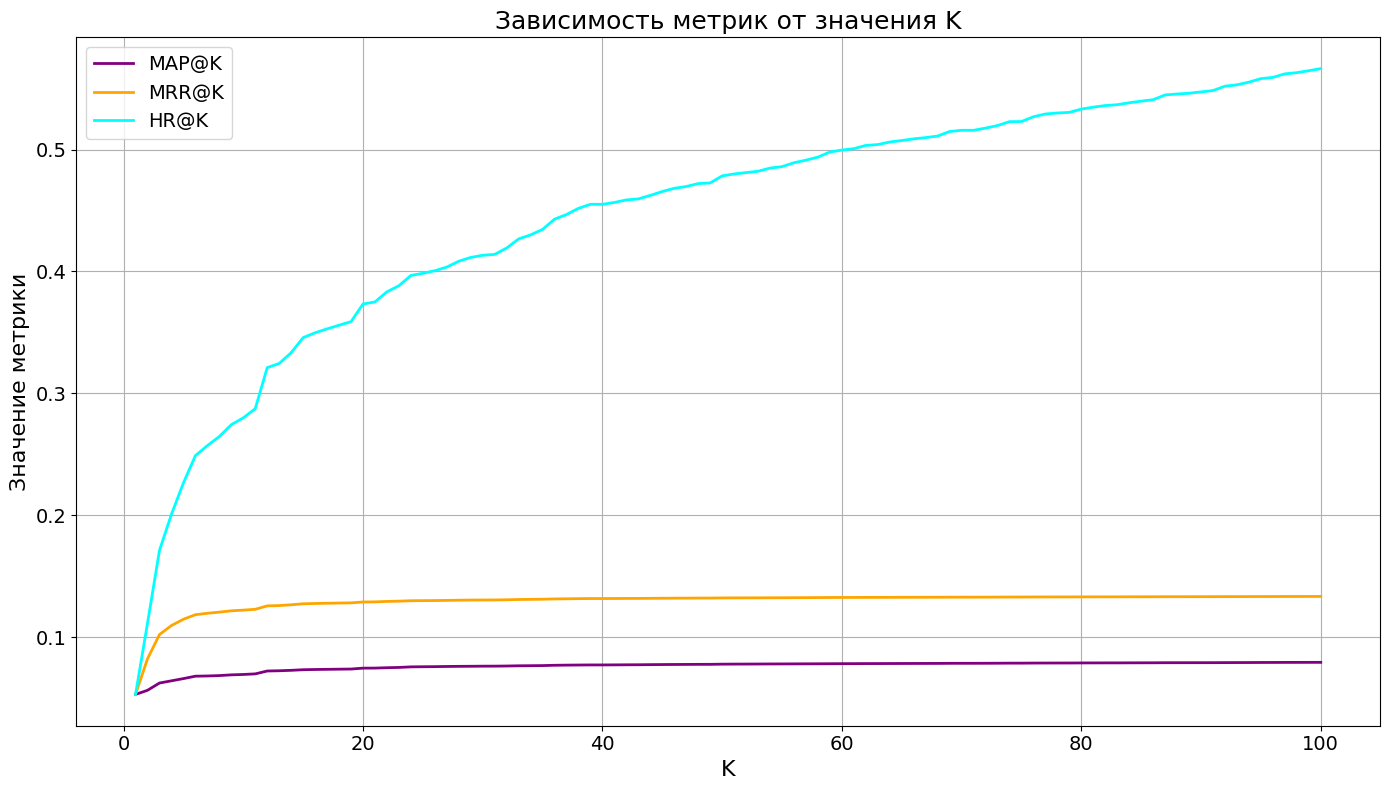

In [93]:
k_values = range(1, 101)
map_values = []
mrr_values = []
hr_values = []

for k in k_values:
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    metrics = evaluate_recommender(joined, 'toppopular_recs')
    map_values.append(metrics['map'])
    mrr_values.append(metrics['mrr'])
    hr_values.append(metrics['hr'])

plt.figure(figsize=(14, 8))

# График MAP@K
plt.plot(k_values, map_values, label="MAP@K", color='purple', linewidth=2)

# График MRR@K
plt.plot(k_values, mrr_values, label="MRR@K", color='orange', linewidth=2)

# График HR@K
plt.plot(k_values, hr_values, label="HR@K", color='cyan', linewidth=2)

plt.xlabel("K", fontsize=16)
plt.ylabel("Значение метрики", fontsize=16)
plt.title("Зависимость метрик от значения K", fontsize=18)

# Легенда,сетка, шрифт
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** Монотонными неубывающими функциями являются MRR@K и HR@K. Это видно из графика, а также, при увеличении top-K, вероятность того, что первый элемент окажется в предсказании увеличивается, поэтому и значения двух метрик возрастают.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:** MAP@K- Данная модель измеряет качество ранжирования рекомендаций. График показывает в преимуществе рост, а это значит, что модель становится лучше в том, чтобы ранжировать релевантные элементы выше нерелевантных. Но, как я уже писала выше, при увеличении масштаба можно заметить, что в каком-то месте график падает. Это может указывать на то, что добавление новых элементов в список рекомендаций снижает общее количество ранжирование, но потом график все-равно возрастает.\
MRR@K - Данная модель измеряет, насколько быстро пользователь может найти первый релевантный элемент. График показывает рост, а это значит, что модель становится лучше в том, чтобы предлагать актуальные видео\
HR@K - Данная модель измеряет, был ли хотя бы один релевантный элемент, который был найден в предсказаниях. Данный график растет стремительнее и даже продолжает свой стремительный рост при top-K > 40 в отличие от остальных моделей. Рост графика означает, что модель становится лучше в том, чтобы покрывать актуальные элементы.**

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:** MAP@K - данная метрика может, как возрастать, так и падать. Это связано с тем, что при добавлении новых элементов список рекомендаций может как улучшить, так и ухулшить качество ранжирования.
MRR@K, HR@K - графики монотонно растут, но в случае метрики MRR@K это зависит от положения первого релевантного элемента, а в случае метрики HR@K- это зависит от общего количества релевантных элементов.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [94]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

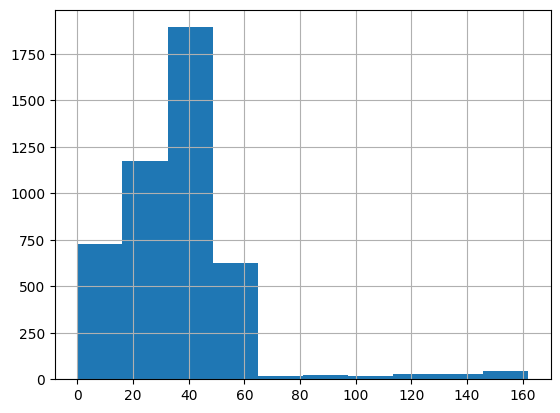

In [95]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

In [96]:
def plot_popularity(item_id):
    popular_items = df.item_id.value_counts()[:300].index.tolist()
    sampled_id = np.random.choice(popular_items)
    sampled_id = item_id

    interactions = df.loc[df.item_id==sampled_id].copy()
    name = items.loc[items.item_id==sampled_id].title.values[0]
    plt.title(name)
    plt.xlabel('Дата')
    plt.ylabel('Количество просмотров')
    interactions.last_watch_dt.hist()

In [97]:
# Найдем список id с резким ростом и падением популярности
variance_df = df.groupby('item_id').agg({'last_watch_dt': 'nunique', 'user_id': 'count'}).rename(columns={'user_id': 'total_views'})
variance_df['avg_daily_views'] = variance_df['total_views'] / variance_df['last_watch_dt']
high_variance_items = variance_df[variance_df['avg_daily_views'] > 200].index.tolist()
high_variance_items[:10]

[142, 341, 1173, 2657, 3734, 3784, 4151, 4218, 4495, 4740]

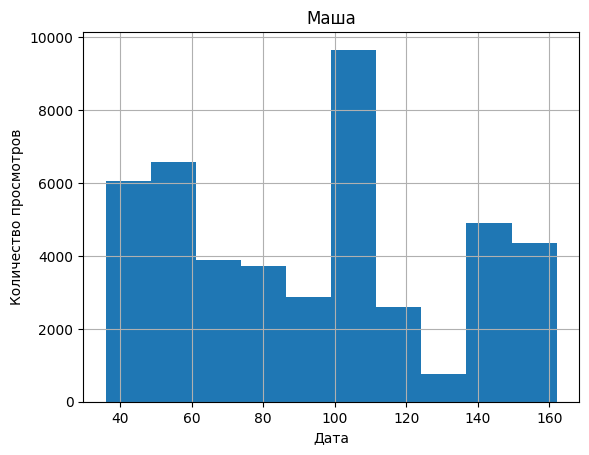

In [98]:
plot_popularity(142)

Наибольшее количество просмотров (более 9.5к) было зафиксировано примерно на 105-й день. Это может указывать на то, что именно в этот период фильм был наиболее популярен.
Возможные причины изменений:
1. Пик может быть связан с выходом фильма или каким-то значимым событием, привлекшим внимание к нему.
2. Спад может быть обусловлен завершением рекламной кампании, уменьшением интереса со стороны зрителей или появлением новых фильмов.


In [99]:
# Постоянная
stable_items = df.groupby('item_id')['last_watch_dt'].nunique().sort_values(ascending=False).index[:100].tolist()
stable_items[:5]

[10353, 15078, 14317, 1659, 12820]

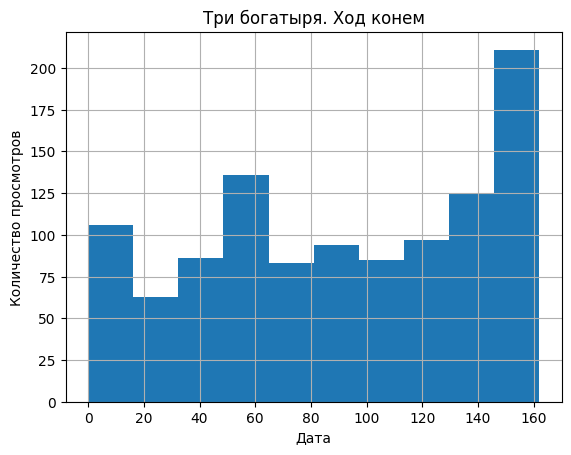

In [100]:
plot_popularity(1659)

 В начале периода количество просмотров было относительно низким (около 100). Затем просмотры постепенно увеличивались, достигая пика около 200 просмотров ближе к концу периода (на 160-й день). Существует период относительной стабильности с небольшими колебаниями между 40-й и 120-й днями, когда количество просмотров колеблется в пределах 50-100. После 120-го дня наблюдается значительный рост просмотров.

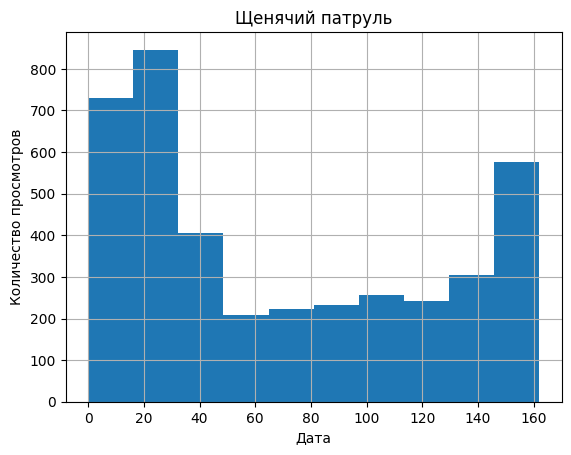

In [101]:
plot_popularity(15078)

 В самом начале периода количество просмотров было очень высоким, достигая более 800. Это может указывать на значительный интерес к мульт-сериалу сразу после его выхода или начала трансляции. Начальный пик может быть обусловлен маркетинговой кампанией при запуске сериала. Стабильный период может быть связан с постоянной аудиторией, которая регулярно смотрит сериал. Второй рост может быть вызван новыми сезонами, специальными эпизодами или другими факторами, привлекающими внимание зрителей.

In [102]:
# Пиковая
peak_items = df.groupby('item_id')['last_watch_dt'].apply(lambda x: x.value_counts().max()).sort_values(ascending=False).index[:100].tolist()
peak_items[:10]

[10440, 15297, 13865, 9728, 3734, 12360, 2657, 6809, 4740, 14488]

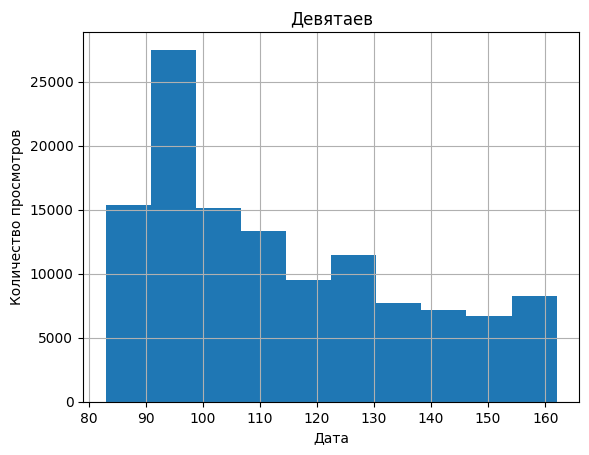

In [103]:
plot_popularity(13865)

В самом начале периода количество просмотров было очень высоким, достигая более 25000. Это может указывать на значительный интерес к фильму сразу после его выхода или начала трансляции. Ближе к концу периода количество просмотров стабилизируется на уровне около 7000-8000 просмотров. Это может указывать на то, что фильм потерял значительную часть своей первоначальной аудитории, но все еще имеет постоянных зрителей. Также фильм военного времени, может быть это сыграло свою роль относительно пику и спаду для данной кинокартины


In [104]:
# Циклическая
from scipy.fft import fft
threshold = 0.2
id = []
for item_id in popular_items:
    interactions = df.loc[df.item_id == item_id]
    daily_counts = interactions.groupby('last_watch_dt').size()
    freqs = fft(daily_counts)
    if np.any(np.abs(freqs[1:]) > threshold):
        id.append(item_id)
id[10:20]

[12192, 9996, 8636, 4740, 7571, 11237, 1844, 12995, 4457, 14431]

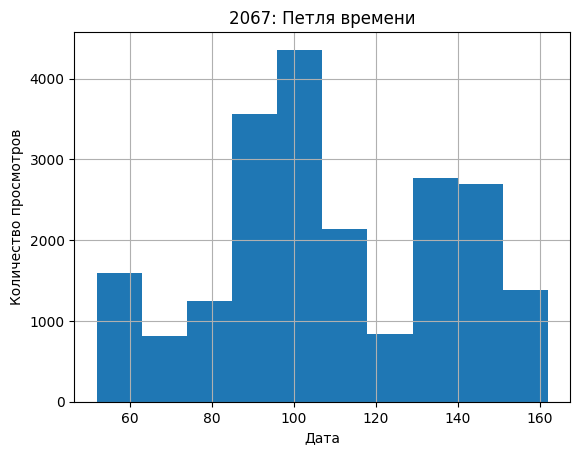

In [105]:
plot_popularity(4457)

В самом начале период количество просмотров было относительно низким, около 1500. Затем происходит постепенный рост просмотров до пика, который достигает более 4000 на 100-й день. Далее интерес к фильму начинает угасать и падает до просмотров ниже 1к, а следом происходит рост почти до 3к просомтров, может быть это связано с рекламой или акциями внутри онлайнкинотеатров, а также различных соцсетей

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [106]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    counts = df[col].value_counts()
    values_to_keep = counts[counts >= min_freq].index
    df = df[df[col].isin(values_to_keep)]

    return df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    filtered_df = df.copy()
    while True:
        n_rows_before = filtered_df.shape[0]

        for col in cols:
            filtered_df = filter_column(filtered_df, col, min_freq)

        n_rows_after = filtered_df.shape[0]

        if n_rows_after == n_rows_before:
            break

    return filtered_df

filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=5)

In [107]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df

filtered_train = df_encode(filtered_train)
filtered_train.sample(5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
4088302,1271,431,148,133,2.0
2767055,277,1489,129,34136,100.0
3358866,2238,315,129,5491,100.0
5373281,3402,167,124,15899,100.0
2149629,1104,483,119,11163,100.0


In [108]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5899x3088 sparse matrix of type '<class 'numpy.float64'>'
	with 107520 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

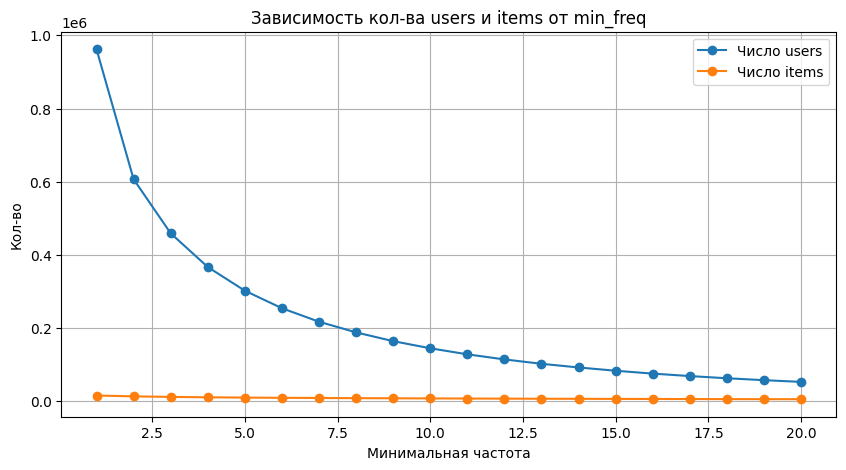

In [109]:
min_freq_values = range(1, 21)

num_users = [filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)['user_id'].nunique() for min_freq in min_freq_values]
num_items = [filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)['item_id'].nunique() for min_freq in min_freq_values]

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(min_freq_values, num_users, marker='o', label="Число users")
plt.plot(min_freq_values, num_items, marker='o', label="Число items")
plt.xlabel("Минимальная частота")
plt.ylabel("Кол-во")
plt.title("Зависимость кол-ва users и items от min_freq")
plt.legend()
plt.grid(True)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [110]:
%%time

def fit_ease(X, reg_weight=100):

  G = X.T @ X
  G += reg_weight * sps.identity(G.shape[0])
  G = G.todense()

  P = np.linalg.inv(G)
  B = P / (-np.diag(P))

  np.fill_diagonal(B, 0.)

  return B

w = fit_ease(matrix)

CPU times: user 4.73 s, sys: 592 ms, total: 5.32 s
Wall time: 3.84 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [111]:
def get_preds(x, item2id, id2item):
    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded == 1] = -np.inf

    ranks = np.argsort(-preds)

    decoded = [id2item[t] for t in ranks if t in id2item][:100]

    return decoded

joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))

In [112]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.07783445158788357, 'mrr': 0.13168104412359471, 'hr': 0.5659}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** EASE показывает лучшие результаты по всем метрикам. Особенно значительное преимущество у HR: 56.6% против 28% у TopPopular. Означает, что EASE боллее релевантный показатель демонстрирует


**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

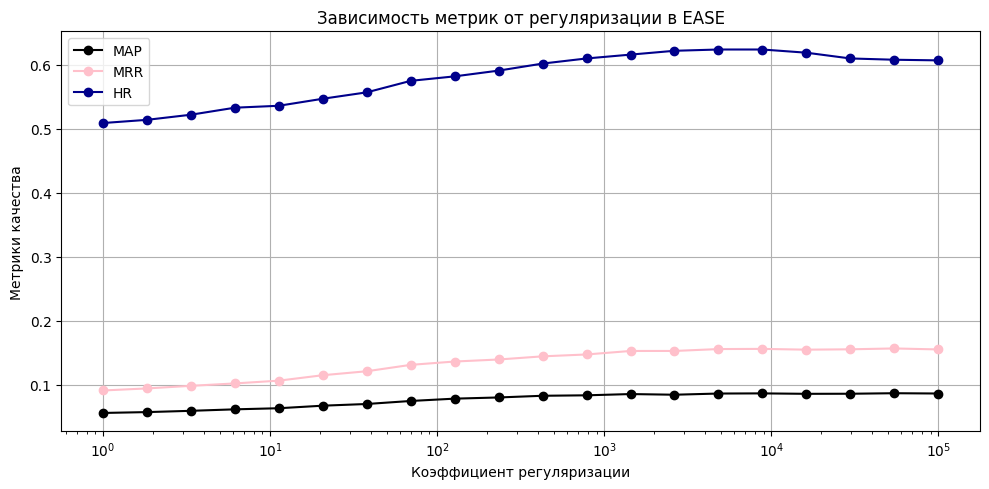

In [113]:
reg_values = np.logspace(0, 5, 20)

# Списки для хранения метрик
hit_rates = []
map_scores = []
mrr_scores = []

w_cache = {reg: fit_ease(matrix, reg_weight=reg) for reg in reg_values}

# Вычисляем метрики для reg_weight
for reg in reg_values:
    w = w_cache[reg]
    sampled_users = joined.sample(frac=0.1, random_state=42)
    sampled_users['ease_preds'] = sampled_users.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    metrics = evaluate_recommender(sampled_users, model_preds='ease_preds')
    map_scores.append(metrics['map'])
    mrr_scores.append(metrics['mrr'])
    hit_rates.append(metrics['hr'])


plt.figure(figsize=(10, 5))

# График MAP
plt.plot(reg_values, map_scores, marker='o', color='black', label="MAP")

# График MRR
plt.plot(reg_values, mrr_scores, marker='o', color='pink', label="MRR")

# График HR
plt.plot(reg_values, hit_rates, marker='o', color='darkblue', label="HR")

# Настройка графиков
plt.xscale("log")
plt.xlabel("Коэффициент регуляризации")
plt.ylabel("Метрики качества")
plt.title("Зависимость метрик от регуляризации в EASE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
# 8.1 Какое значение гиперпараметра является наилучшим?

best_reg_map = reg_values[np.argmax(map_scores)]
best_reg_mrr = reg_values[np.argmax(mrr_scores)]
best_reg_hr = reg_values[np.argmax(hit_rates)]

print(f"Лучшее значение для MAP@K: {best_reg_map}")
print('-' * 60)
print(f"Лучшее значение для MRR@K: {best_reg_mrr}")
print('-' * 60)
print(f"Лучшее значение для HR@K: {best_reg_hr}")
print('-' * 60)

Лучшее значение для MAP@K: 54555.947811685146
------------------------------------------------------------
Лучшее значение для MRR@K: 54555.947811685146
------------------------------------------------------------
Лучшее значение для HR@K: 4832.930238571752
------------------------------------------------------------


Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:** код в ячейке выше

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** При малых значениях регуляризации, модель может переобучаться, что приводит к снижению качества рекомендаций.Тюнинг EASE относительно быстрый, так как обучение модели сводится к решению задачи линейной алгебры. Логарифмическая сетка позволяет лучше исследовать широкий диапазон регуляризации.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

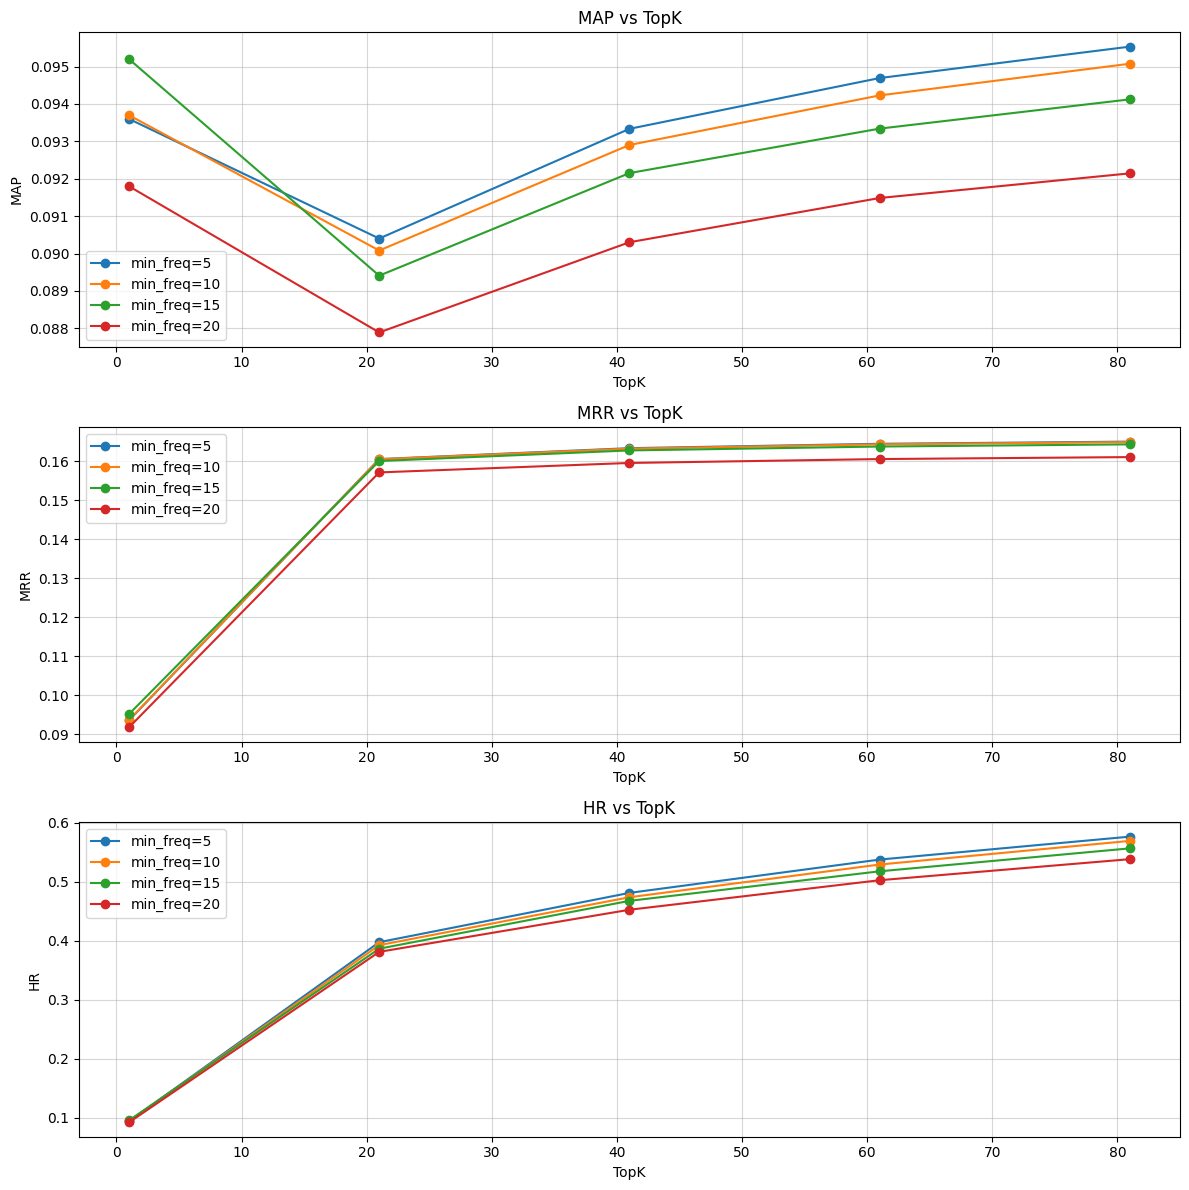

In [124]:
freq_array = [5, 10, 15, 20]
topk_values = list(range(1, 101, 20))

results = {mf: {'map': [], 'mrr': [], 'hr': []} for mf in freq_array}

def plot_metrics(results, freq_array, topk_values):
    plt.figure(figsize=(12, 12))

    # График MAP
    plt.subplot(3, 1, 1)
    for mf in freq_array:
        plt.plot(topk_values, results[mf]['map'], label=f"min_freq={mf}", marker='o', linestyle='-')
    plt.title("MAP vs TopK")
    plt.xlabel("TopK")
    plt.ylabel("MAP")
    plt.legend()
    plt.grid(True, linestyle="-", alpha=0.5)

    # График MRR
    plt.subplot(3, 1, 2)
    for mf in freq_array:
        plt.plot(topk_values, results[mf]['mrr'], label=f"min_freq={mf}", marker='o', linestyle='-')
    plt.title("MRR vs TopK")
    plt.xlabel("TopK")
    plt.ylabel("MRR")
    plt.legend()
    plt.grid(True, linestyle="-", alpha=0.5)

    # График HR
    plt.subplot(3, 1, 3)
    for mf in freq_array:
        plt.plot(topk_values, results[mf]['hr'], label=f"min_freq={mf}", marker='o', linestyle='-')
    plt.title("HR vs TopK")
    plt.xlabel("TopK")
    plt.ylabel("HR")
    plt.legend()
    plt.grid(True, linestyle="-", alpha=0.5)

    plt.tight_layout()
    plt.show()

for min_freq in freq_array:
    filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=min_freq)

    item2id = {k: v for v, k in enumerate(filtered_train.item_id.unique())}
    user2id = {k: v for v, k in enumerate(filtered_train.user_id.unique())}
    id2item = {v: k for k, v in item2id.items()}
    id2user = {v: k for k, v in user2id.items()}
    filtered_train['user_id'] = filtered_train.user_id.map(user2id)
    filtered_train['item_id'] = filtered_train.item_id.map(item2id)

    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]),
         (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id))
    )

    w = fit_ease(matrix, reg_weight=10000)

    # Вычисление метрик для значений topk
    for k in topk_values:
        joined['ease_preds_topk'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item)[:k])
        scores = evaluate_recommender(joined, model_preds='ease_preds_topk')
        results[min_freq]['map'].append(scores['map'])
        results[min_freq]['mrr'].append(scores['mrr'])
        results[min_freq]['hr'].append(scores['hr'])

plot_metrics(results, freq_array, topk_values)

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** Соглавно графикам, хочется сделать акцент на том, что качество рекомендаций зависят от выбранного TOPK. Также все зависит от параметров. (и да, графики действительно могут наслатваться друг на друга, столкнулся с таким при первом переборе)

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [115]:
import random

def print_recommendations_for_random_items(item2id, id2item, items, w, num_recommendations=5, num_samples=10, random_seed=42):
    random.seed(random_seed)

    random_items = random.sample(list(items['item_id']), num_samples)

    for item_id in random_items:
        item_title = items[items['item_id'] == item_id]['title'].values[0]
        print(f"Рекомендации для фильма '{item_title}':")

        recommended_items = get_preds([(item_id, 0)], item2id, id2item)[:num_recommendations]

        for recommended_item in recommended_items:
            recommended_title = items[items['item_id'] == recommended_item]['title'].values[0]
            print(f"  - {recommended_title}")
        print("\n")

print_recommendations_for_random_items(item2id, id2item, items, w, random_seed=42)


Рекомендации для фильма 'Медсестра (полная версия)':
  - Три богатыря. Ход конем
  - Человек-муравей
  - Очень голодные игры
  - Две женщины
  - Большой собачий побег


Рекомендации для фильма 'Кавардак':
  - Три богатыря. Ход конем
  - Человек-муравей
  - Очень голодные игры
  - Две женщины
  - Большой собачий побег


Рекомендации для фильма 'Спасти рядового Переса':
  - Три богатыря. Ход конем
  - Человек-муравей
  - Очень голодные игры
  - Две женщины
  - Большой собачий побег


Рекомендации для фильма 'Безжалостный город':
  - Три богатыря. Ход конем
  - Человек-муравей
  - Очень голодные игры
  - Две женщины
  - Большой собачий побег


Рекомендации для фильма 'Люди Икс: Первый класс':
  - Люди Икс: Дни минувшего будущего
  - Люди Икс: Апокалипсис
  - Люди Икс: Начало. Росомаха
  - Мстители: Финал
  - Чёрная пантера


Рекомендации для фильма 'Тайна корабельных часов':
  - Три богатыря. Ход конем
  - Человек-муравей
  - Очень голодные игры
  - Две женщины
  - Большой собачий побег



Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** В 9 из 10 слачаев рекомендации для разных фильмов одинаковы, это указывает на то, что модель не очень хорошая, она не учитывает специфику исходного фильма и выдает универсальные рекомендации, основанные на общей популярности или общих взаимосвязях между фильмами.
К хорошим рекомендациям можно отнести рекомендации для фильма "Люди Икс: Первый класс" т.к. они более релевантны и рекомендует другие части данного фильма
Плохие примеры бывают по разным причинам. Например, если пользователи смотрят одни и те же популярные фильмы независимо от их предпочтений.